<a href="https://colab.research.google.com/github/Chaitanya007-Con/Experiments/blob/main/Prediciting_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Study the stationarity of three stocks from three different industries.
# Plot closing prices, model them with either simple or double exponential smoothing, and test to see if they're stationary.
# Use a random forest from Scikit-learn to predict stock prices for your three chosen stocks, and see how far into the future you can go.


In [2]:
#installing pkg to read financial data
!pip install pandas_datareader

In [3]:
#*****First flow is for APPLE Inc********.

In [4]:
#pandas datareader extracts data as dataframes from various internet sources
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
start= datetime.datetime(2010, 8, 1)
end= datetime.datetime(2020, 1, 1)
aapl= web.DataReader('AAPL','yahoo',start,end)
aapl.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-08-02,9.378214,9.272143,9.301429,9.351786,428055600.0,8.055286
2010-08-03,9.402143,9.265000,9.321786,9.354643,417653600.0,8.057750
2010-08-04,9.438571,9.296786,9.387143,9.392143,420375200.0,8.090052
2010-08-05,9.399286,9.305357,9.347500,9.346429,289097200.0,8.050671
2010-08-06,9.338929,9.201071,9.277857,9.288929,444897600.0,8.001143
2010-08-09,9.362500,9.270357,9.338571,9.348214,303128000.0,8.052209
2010-08-10,9.301786,9.198214,9.280357,9.264643,451920000.0,7.980224
2010-08-11,9.131786,8.921786,9.121429,8.935357,620054400.0,7.696590
2010-08-12,9.039286,8.790000,8.810357,8.992500,534920400.0,7.745813


In [6]:
#. The closing price is the 'raw' price which is just the cash value of the last transacted price before 
#the market closes.The adjusted closing price factors in anything that might affect the stock price after 
#the market closes.accurately reflect that stock's value after accounting for any corporate actions.
#It is considered to be the true price of that stock and is often used when 
#examining historical returns or performing a detailed analysis of historical returns.
#Therefore, we will consider [Adj Close] and not [Close] for further analysis

''

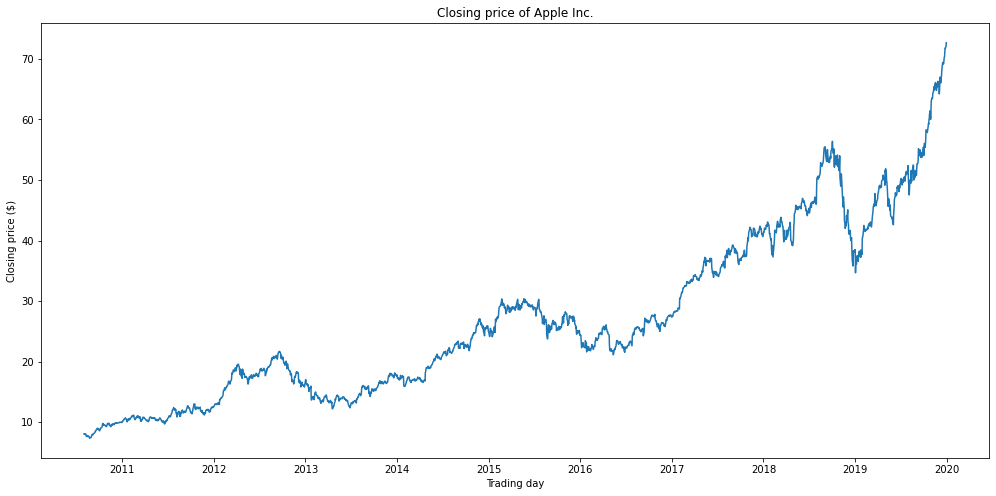

In [7]:
#Plotting closing price for Apple Inc.
plt.figure(figsize=(17, 8))
plt.plot(aapl['Adj Close'])
plt.title('Closing price of Apple Inc.')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
;


In [8]:
#Clearly, the stock price is not stationary

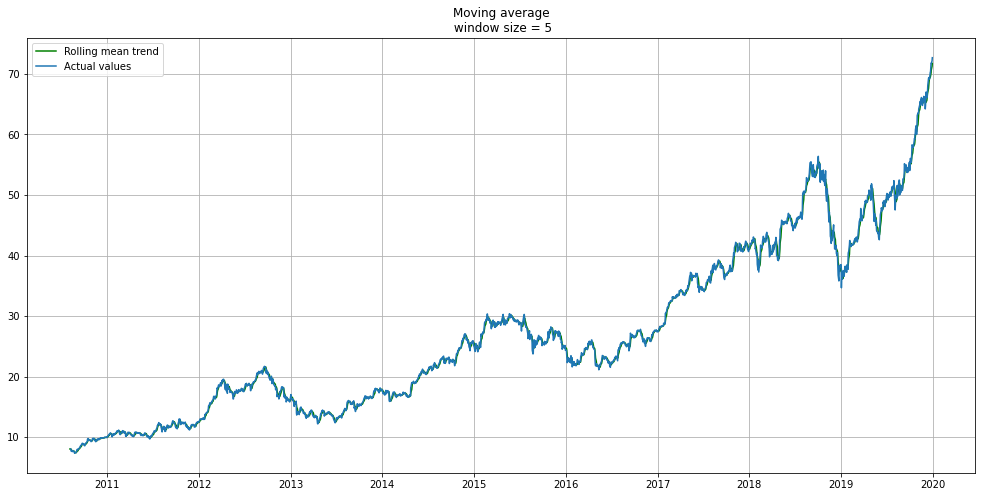

In [9]:
#Calculating moving average to smooth our time series plot:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(aapl['Adj Close'], 5)



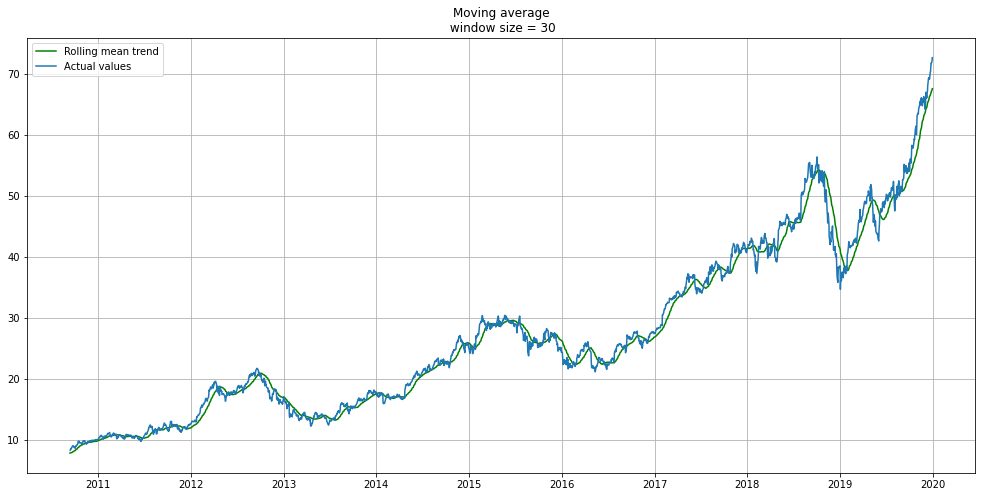

In [10]:
#Smoothing by previous month for Apple:
plot_moving_average(aapl['Adj Close'], 30)

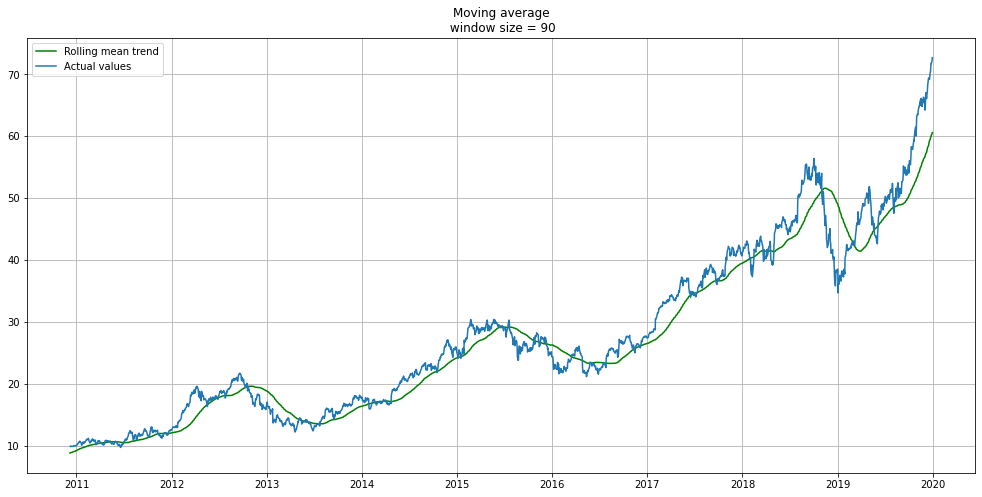

In [11]:
#Smoothing by previous quarter for Apple:
plot_moving_average(aapl['Adj Close'], 90)

In [12]:
#Above plot indicates, the stock is not likely to go down soon
##Lets use various exponential Smoothing techniques

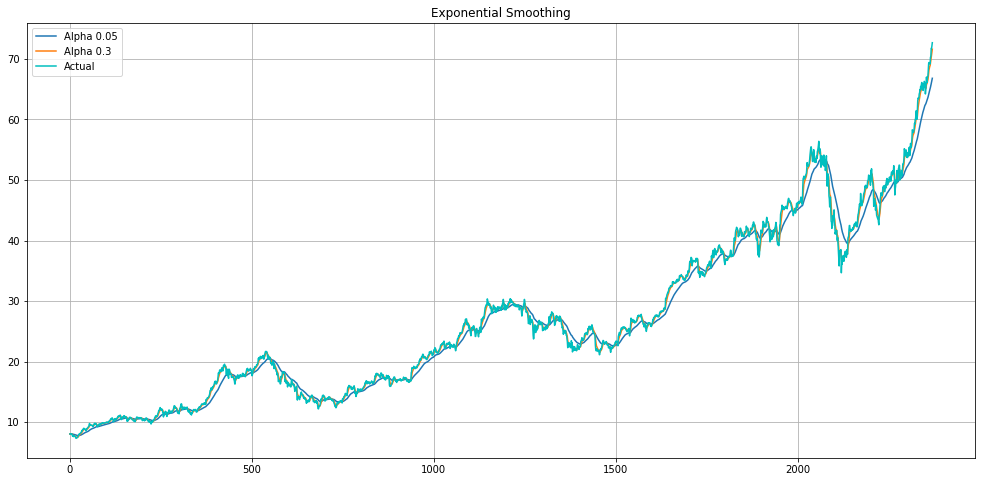

In [13]:
#Simple exponential smoothing using smoothing factors 0.05,0.3:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(aapl['Adj Close'], [0.05, 0.3])

In [14]:
#an alpha value of 0.05 smoothed the curve while picking up most of the upward and downward trends.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


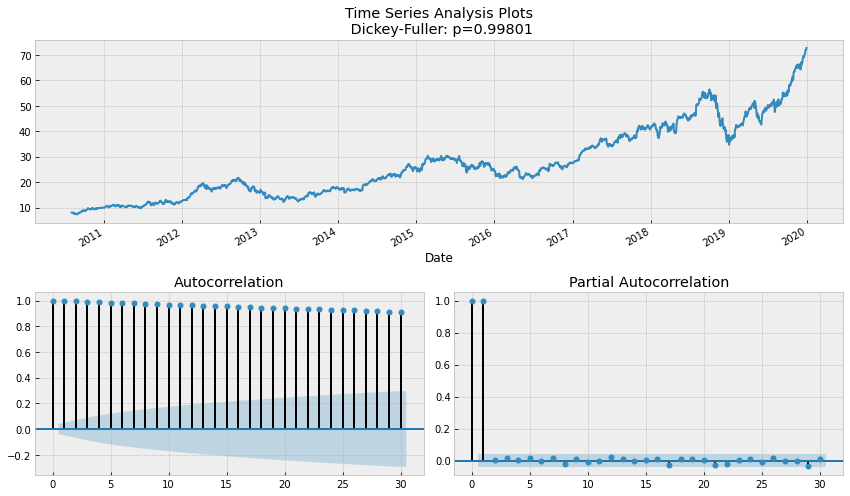

In [15]:
#Running Dickey Fuller test to check the stationarity of stock(point estimate<0.01)
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(aapl['Adj Close'], lags=30)

In [16]:
#p=0.99, the plot is not stationary and high autocorrelation indicates there is no clear seasonality

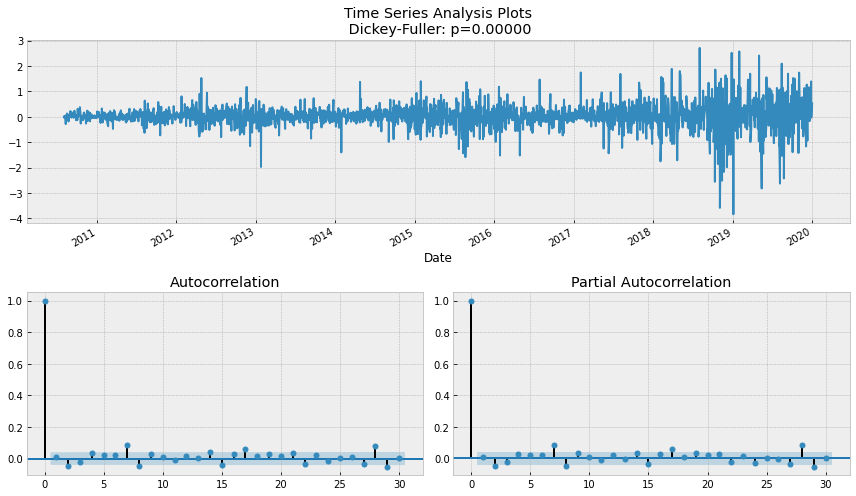

In [17]:
#Making plot stationary
#Therefore, to get rid of the high autocorrelation and to make the process stationary,
#let’s take the first difference: 
#We simply subtract the time series from itself with a lag of one day, and we get:
## Take the first difference to remove to make the process stationary
aapl_diff = aapl['Adj Close'] - aapl['Adj Close'].shift(1)

tsplot(aapl_diff[1:], lags=30)

In [18]:
#Using Random forest from Scikit learn to predict stocks:

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [19]:
#list columns of our dataset
aapl.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [20]:
 # Shift Adj Close down to predict next day
pd.concat([aapl['Adj Close'], aapl['Adj Close'].shift(-1)], axis=1)

,Adj Close,Adj Close
Date,,
2010-08-02,8.055286,8.057750
2010-08-03,8.057750,8.090052
2010-08-04,8.090052,8.050671
2010-08-05,8.050671,8.001143
2010-08-06,8.001143,8.052209
...,...,...
2019-12-24,70.353882,71.749733
2019-12-26,71.749733,71.722488
2019-12-27,71.722488,72.148178


In [21]:
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-08-02,9.378214,9.272143,9.301429,9.351786,428055600.0,8.055286
2010-08-03,9.402143,9.265000,9.321786,9.354643,417653600.0,8.057750
2010-08-04,9.438571,9.296786,9.387143,9.392143,420375200.0,8.090052
2010-08-05,9.399286,9.305357,9.347500,9.346429,289097200.0,8.050671
2010-08-06,9.338929,9.201071,9.277857,9.288929,444897600.0,8.001143


In [22]:
X = aapl.iloc[:,0:1].values
y = aapl.iloc[:, 1].values


In [23]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X,y)

# Predicting a new result
samp = [[2021]]
y_pred = regressor.predict(samp)
print(y_pred)

[71.95264877]


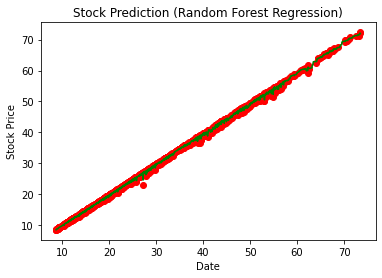

In [24]:
# Visualising the Random Forest Regression results
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'green')
plt.title('Stock Prediction (Random Forest Regression)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [25]:
#adding more features - High Low Percentage and Percentage Change.
dfreg = aapl.loc[:,['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (aapl['High'] - aapl['Low']) / aapl['Close'] * 100.00
dfreg['PCT_change'] = (aapl['Close'] - aapl['Open']) / aapl['Open'] * 100
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-12-24,70.353882,48478800.0,0.693004,-0.147534
2019-12-26,71.749733,93121200.0,1.821254,1.787092
2019-12-27,71.722488,146266000.0,2.018636,-0.453424
2019-12-30,72.148178,144114400.0,2.562432,0.711669
2019-12-31,72.675339,100805600.0,1.416654,1.283069


In [26]:
import math
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# Drop missing values
dfreg = dfreg.fillna(value=-99999)

# Separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating label
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# scale the feature matrix X
X = preprocessing.scale(X)

# get train and test set
X_late = X[-forecast_out:]
X = X[:-forecast_out]
y = dfreg['label'][:-forecast_out]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2229, 4)
(118, 4)
(2229,)
(118,)


In [28]:
#Prediction Using KNN
from sklearn.neighbors import KNeighborsRegressor

In [29]:
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [30]:
confidenceknn = clfknn.score(X_test, y_test)
print("KNN Regression: ", confidenceknn)

KNN Regression:  -1.3684571488594677


In [31]:
aapl.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.353882
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.749733
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.722488
2019-12-30,73.172501,71.305000,72.364998,72.879997,144114400.0,72.148178
2019-12-31,73.419998,72.379997,72.482498,73.412498,100805600.0,72.675339


In [32]:
last_date = dfreg.iloc[-1].name

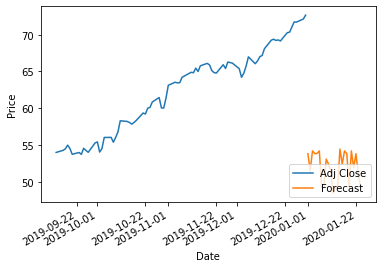

In [33]:
forecast_set = clfknn.predict(X_late)
dfreg['Forecast'] = np.nan



last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(100).plot()
dfreg['Forecast'].tail(100).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [34]:
#*****Flow is for EXXON Inc********.

In [35]:
exxon= web.DataReader('XOM','yahoo',start,end)
exxon.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-08-02,62.040001,60.610001,60.639999,61.939999,28144000.0,41.368778
2010-08-03,62.990002,61.880001,61.980000,62.720001,31075800.0,41.889740
2010-08-04,62.889999,62.270000,62.860001,62.720001,21033800.0,41.889740
2010-08-05,62.709999,61.849998,62.279999,62.709999,19985300.0,41.883057
2010-08-06,62.500000,61.250000,61.919998,61.970001,23097300.0,41.388817
2010-08-09,62.669998,62.180000,62.560001,62.450001,14731300.0,41.709404
2010-08-10,62.169998,61.450001,61.849998,61.930000,23188500.0,41.362118
2010-08-11,60.660000,60.200001,60.549999,60.389999,24281300.0,40.622177
2010-08-12,60.560001,59.560001,59.700001,60.230000,16951300.0,40.514545


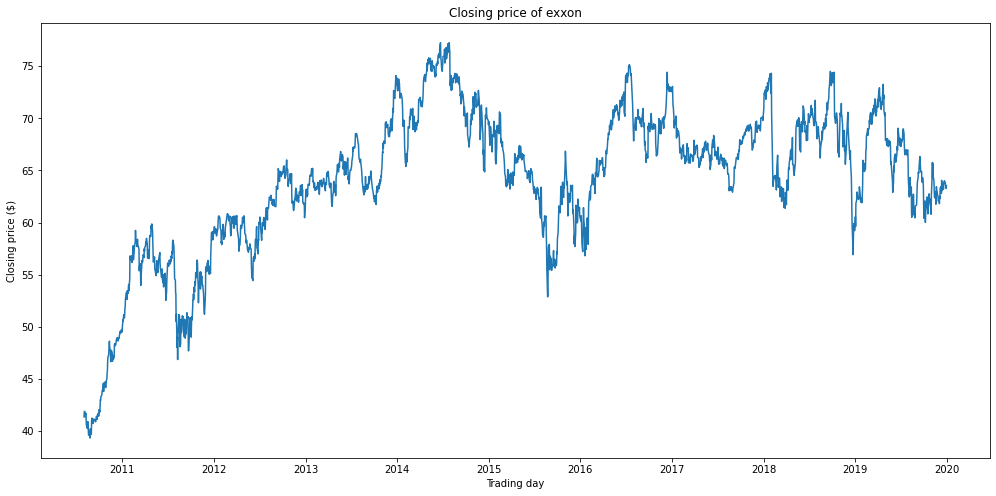

In [36]:
##Plotting closing price for exxon.
plt.figure(figsize=(17, 8))
plt.plot(exxon['Adj Close'])
plt.title('Closing price of exxon')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)

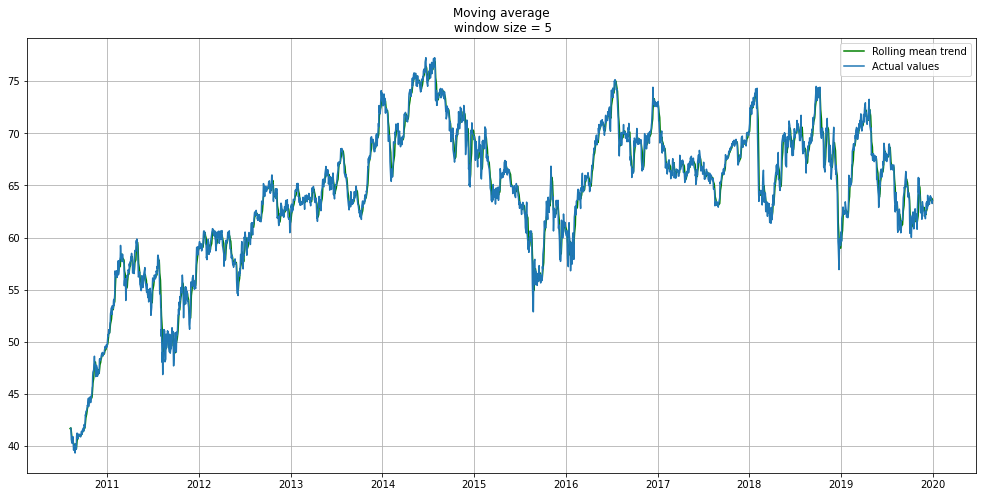

In [37]:
#Smooth by the previous 5 days for exxon(by week)
plot_moving_average(exxon['Adj Close'], 5)

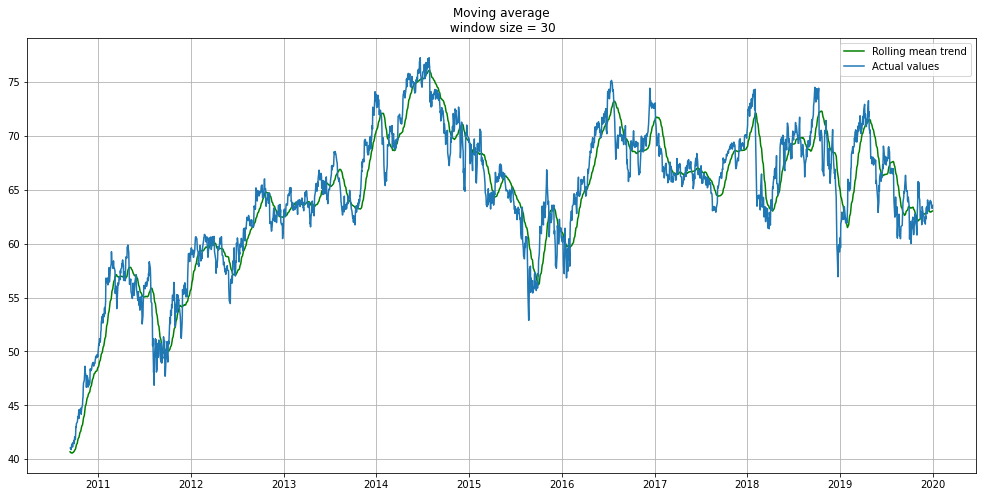

In [38]:
#Smooth by the previous month:
plot_moving_average(exxon['Adj Close'], 30)

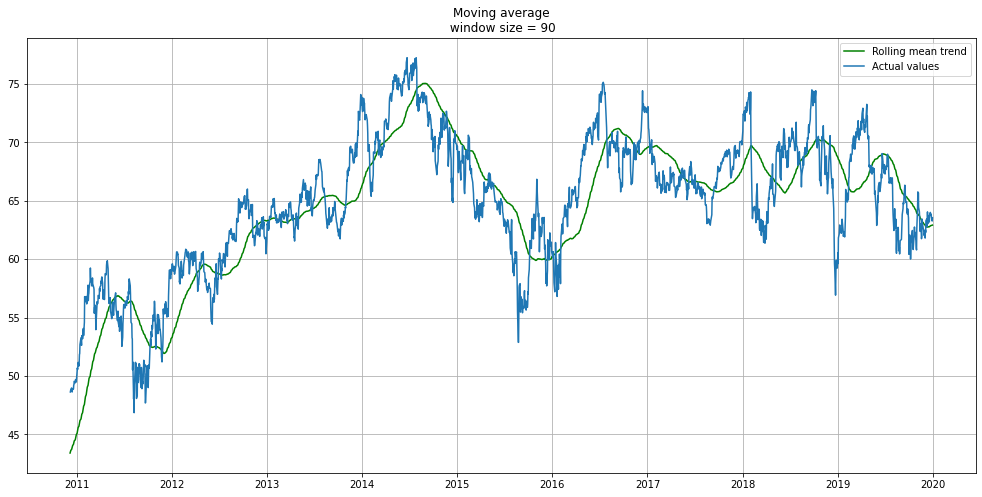

In [39]:
#Smooth by the previous quarter:
plot_moving_average(exxon['Adj Close'], 90)

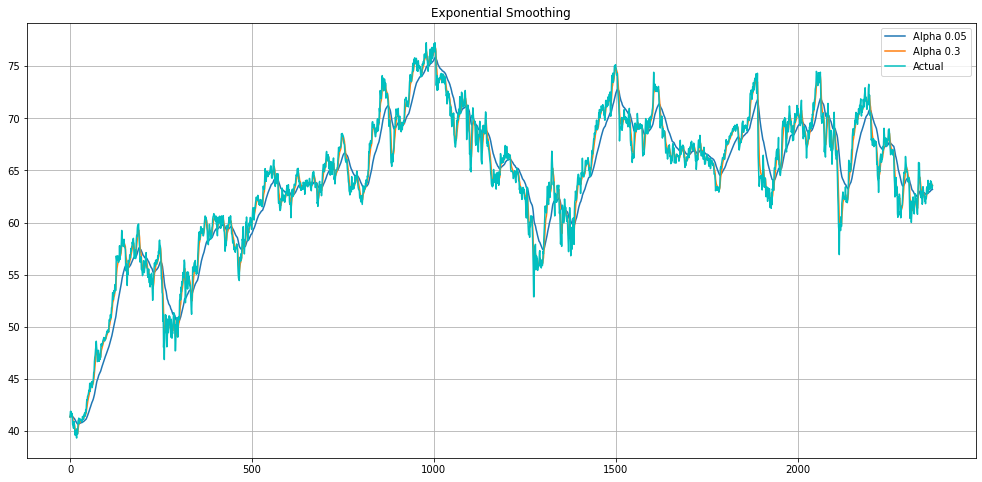

In [40]:
#Simple exponential smoothing using smoothing factors 0.05,0.3:
plot_exponential_smoothing(exxon['Adj Close'], [0.05, 0.3])

In [41]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
        

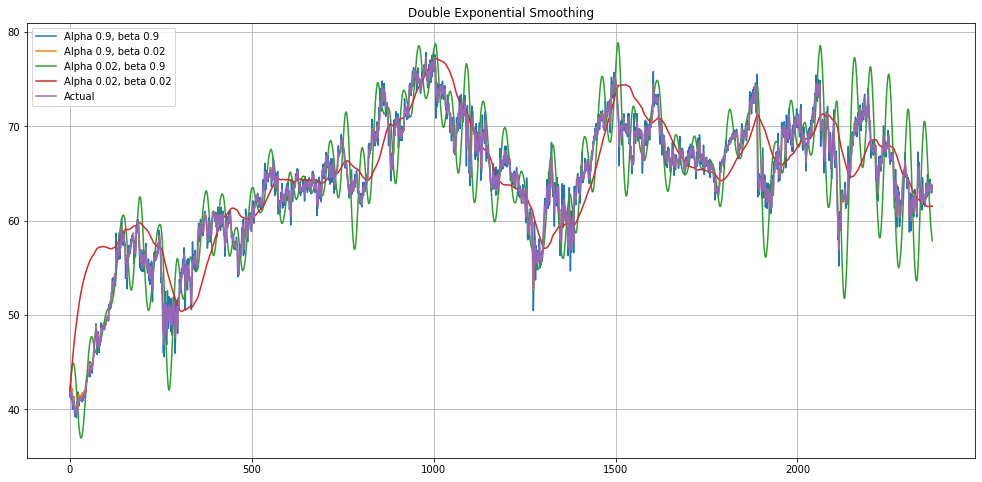

In [42]:
#Using double exponential smoothing for exxon:
plot_double_exponential_smoothing(exxon['Adj Close'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

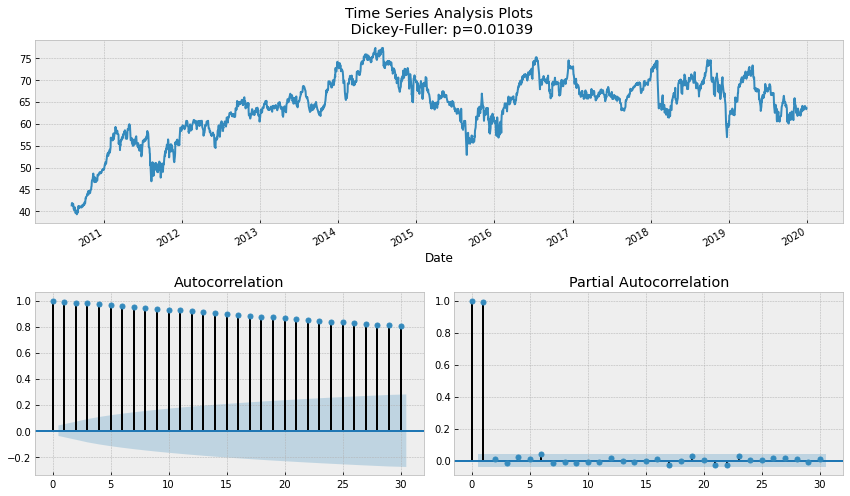

In [43]:
#Running Dickey Fuller test to check the stationarity of stock(point estimate<0.01)
tsplot(exxon['Adj Close'], lags=30)

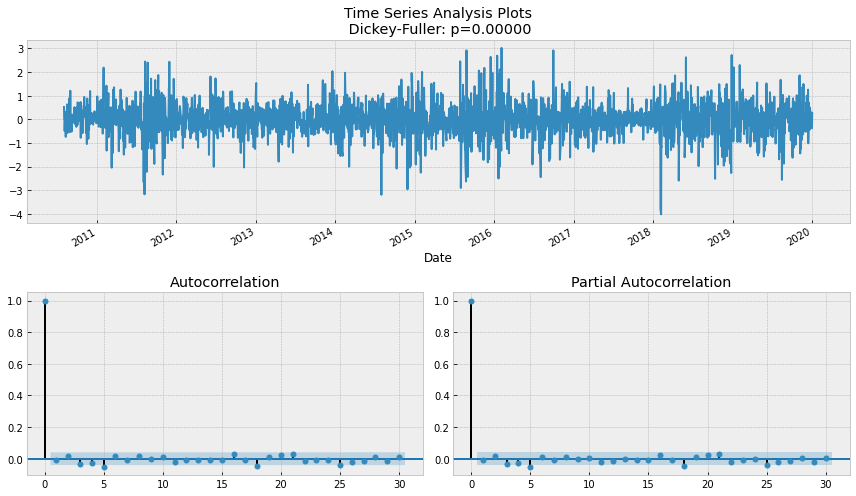

In [44]:
#Making plot stationary
#Therefore, to get rid of the high autocorrelation and to make the process stationary,
#let’s take the first difference: 
#We simply subtract the time series from itself with a lag of one day, and we get:
## Take the first difference to remove to make the process stationary
exxon_diff = exxon['Adj Close'] - exxon['Adj Close'].shift(1)

tsplot(exxon_diff[1:], lags=30)

In [45]:
#list columns of our dataset
exxon.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [46]:
# Shift Adj Close down to predict next day
pd.concat([exxon['Adj Close'], exxon['Adj Close'].shift(-1)], axis=1)

,Adj Close,Adj Close
Date,,
2010-08-02,41.368778,41.889740
2010-08-03,41.889740,41.889740
2010-08-04,41.889740,41.883057
2010-08-05,41.883057,41.388817
2010-08-06,41.388817,41.709404
...,...,...
2019-12-24,63.758801,63.858959
2019-12-26,63.858959,63.640423
2019-12-27,63.640423,63.267101


In [47]:
#adding more features - High Low Percentage and Percentage Change.
dfreg = exxon.loc[:,['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (exxon['High'] - exxon['Low']) / exxon['Close'] * 100.00
dfreg['PCT_change'] = (exxon['Close'] - exxon['Open']) / exxon['Open'] * 100
dfreg.tail()


,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-12-24,63.758801,3979400.0,0.842611,-0.469086
2019-12-26,63.858959,8840200.0,0.698699,-0.085490
2019-12-27,63.640423,10516100.0,0.615253,-0.441592
2019-12-30,63.267101,12689400.0,1.496835,-0.870300
2019-12-31,63.540272,13151800.0,1.132131,1.101133


In [48]:
import math
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [49]:
# Drop missing values
dfreg = dfreg.fillna(value=-99999)

# Separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating label
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# scale the feature matrix X
X = preprocessing.scale(X)
# get train and test set
X_late = X[-forecast_out:]
X = X[:-forecast_out]
y = dfreg['label'][:-forecast_out]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

In [50]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2229, 4)
(118, 4)
(2229,)
(118,)


In [51]:
#Prediction Using KNN
from sklearn.neighbors import KNeighborsRegressor

clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

confidenceknn = clfknn.score(X_test, y_test)
print("KNN Regression: ", confidenceknn)


KNN Regression:  -3.5818176478854915


In [52]:
exxon.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-24,70.500000,69.910004,70.349998,70.019997,3979400.0,63.758801
2019-12-26,70.500000,70.010002,70.190002,70.129997,8840200.0,63.858959
2019-12-27,70.309998,69.879997,70.199997,69.889999,10516100.0,63.640423
2019-12-30,70.440002,69.400002,70.089996,69.480003,12689400.0,63.267101
2019-12-31,69.800003,69.010002,69.019997,69.779999,13151800.0,63.540272


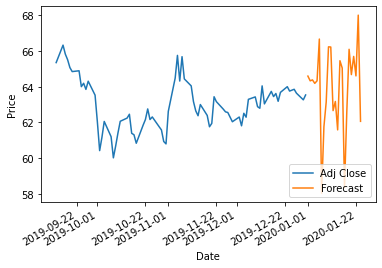

In [53]:
last_date = dfreg.iloc[-1].name

forecast_set = clfknn.predict(X_late)
dfreg['Forecast'] = np.nan



last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(100).plot()
dfreg['Forecast'].tail(100).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [54]:
#*****Flow is for FOX********.

In [55]:
fox= web.DataReader('FOX','yahoo',start,end)
fox.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-13,39.299999,38.000000,38.599998,39.200001,306000.0,38.081100
2019-03-14,40.650002,39.320000,39.500000,39.959999,279700.0,38.819408
2019-03-15,41.049999,40.500000,40.549999,41.020000,164200.0,39.849152
2019-03-18,41.730000,40.470001,41.730000,40.860001,581700.0,39.693718
2019-03-19,41.400002,39.049999,41.400002,39.549999,2540200.0,38.421108
2019-03-20,39.851002,37.459999,39.849998,37.599998,5147900.0,36.526764
2019-03-21,38.910000,37.840000,38.000000,38.880001,8865500.0,37.770233
2019-03-22,38.840000,36.549999,38.759998,37.459999,4902500.0,36.390766
2019-03-25,37.810001,36.349998,37.570000,36.450001,4035100.0,35.409595


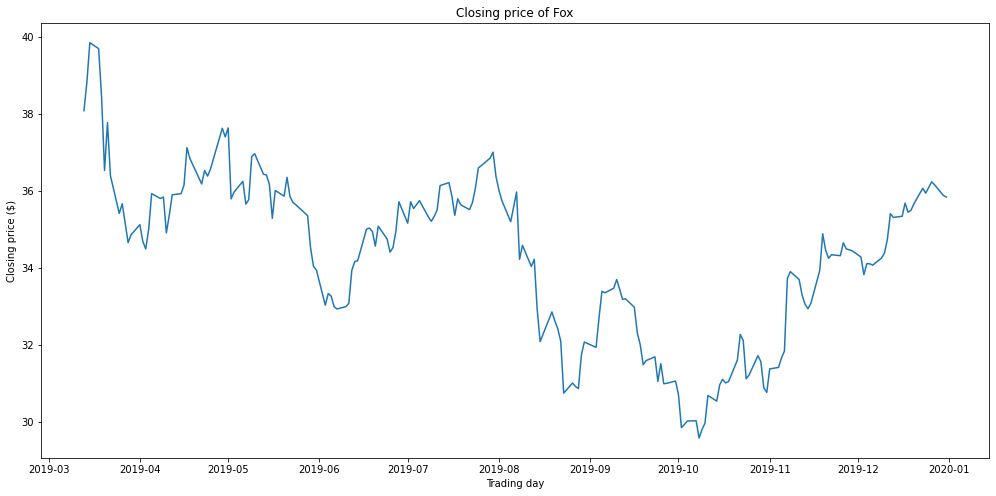

In [56]:
##Plotting closing price for Fox.
plt.figure(figsize=(17, 8))
plt.plot(fox['Adj Close'])
plt.title('Closing price of Fox')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)

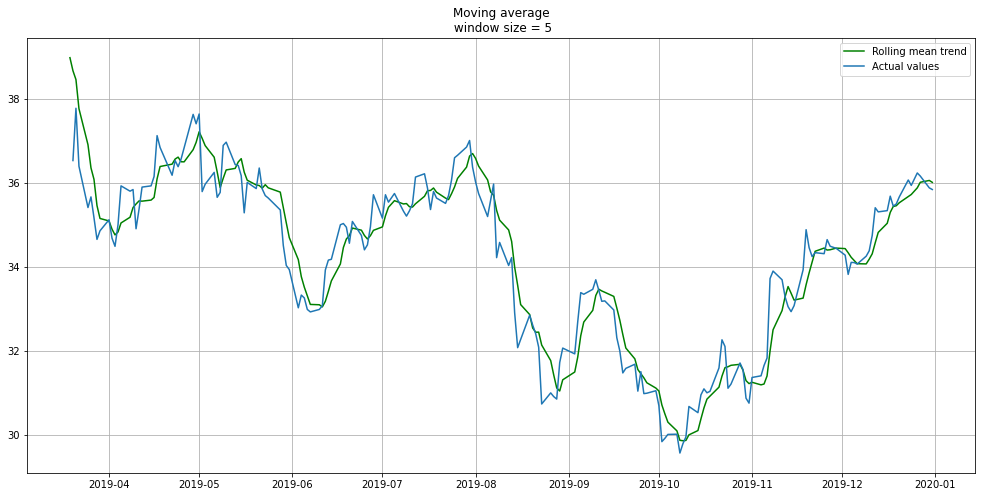

In [57]:
#Smooth by the previous 5 days (by week) for FOX
plot_moving_average(fox['Adj Close'], 5)

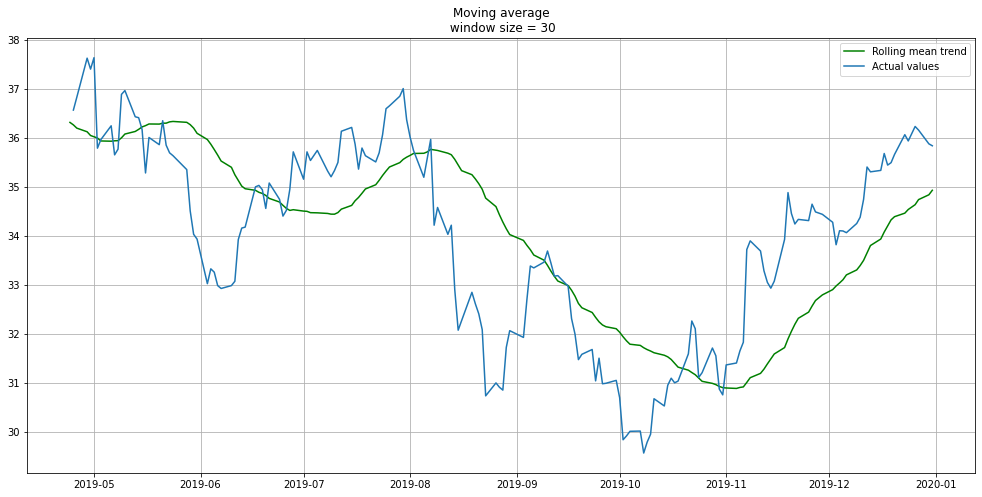

In [58]:
#Smooth by the previous month for FOX
plot_moving_average(fox['Adj Close'], 30)

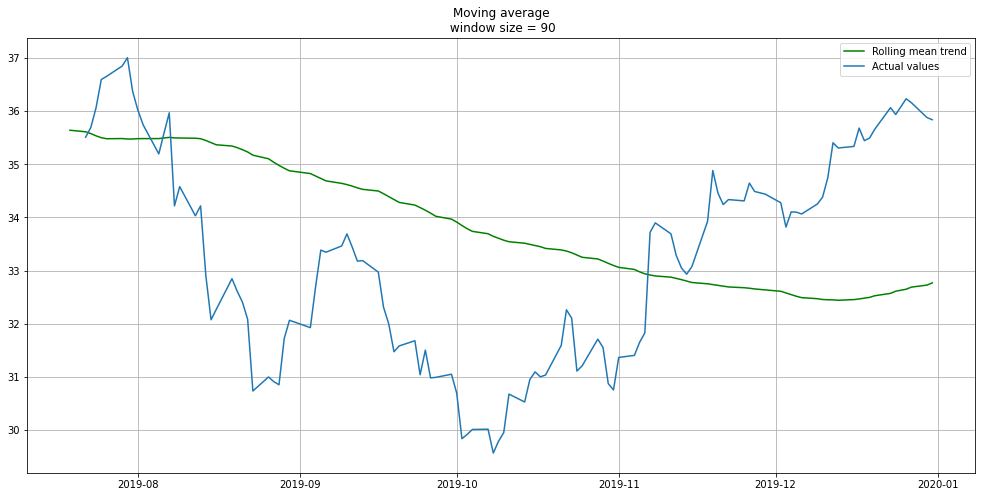

In [59]:
#Smooth by the previous quarter for FOX
plot_moving_average(fox['Adj Close'], 90)

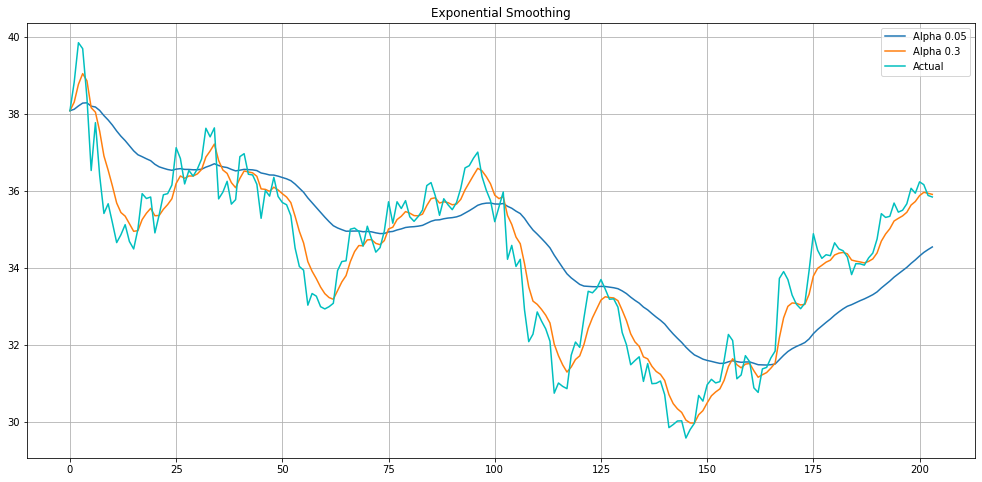

In [60]:
#Simple exponential smoothing using smoothing factors 0.05,0.3:
plot_exponential_smoothing(fox['Adj Close'], [0.05, 0.3])

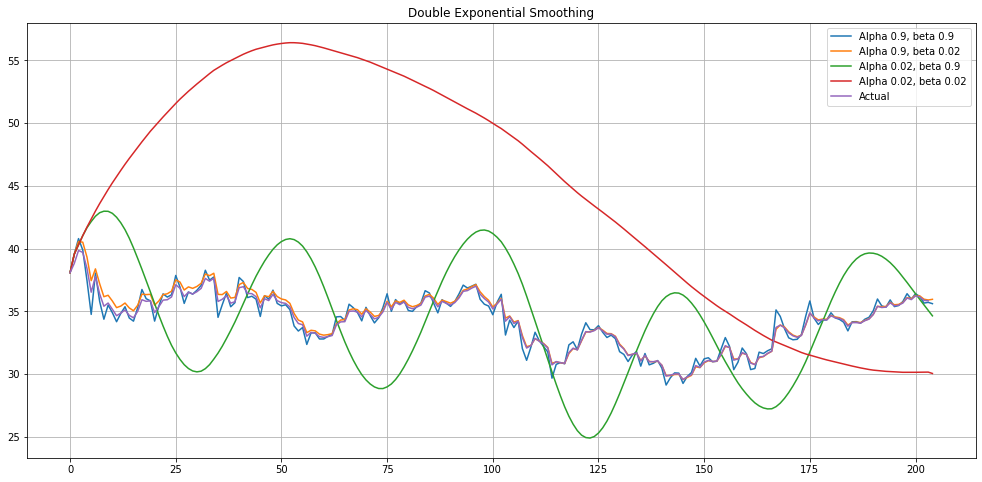

In [61]:
#Using double exponential smoothing for FOX:
plot_double_exponential_smoothing(fox['Adj Close'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

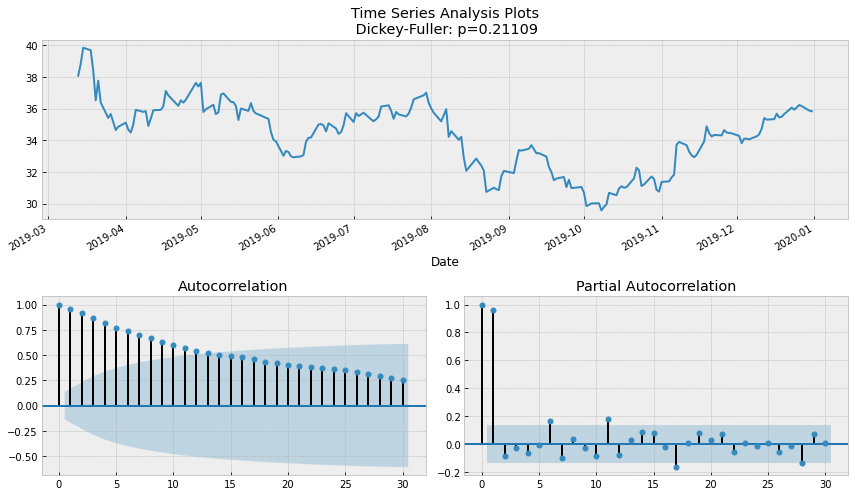

In [62]:
#Running Dickey Fuller test to check the stationarity of stock(point estimate<0.01)
tsplot(fox['Adj Close'], lags=30)

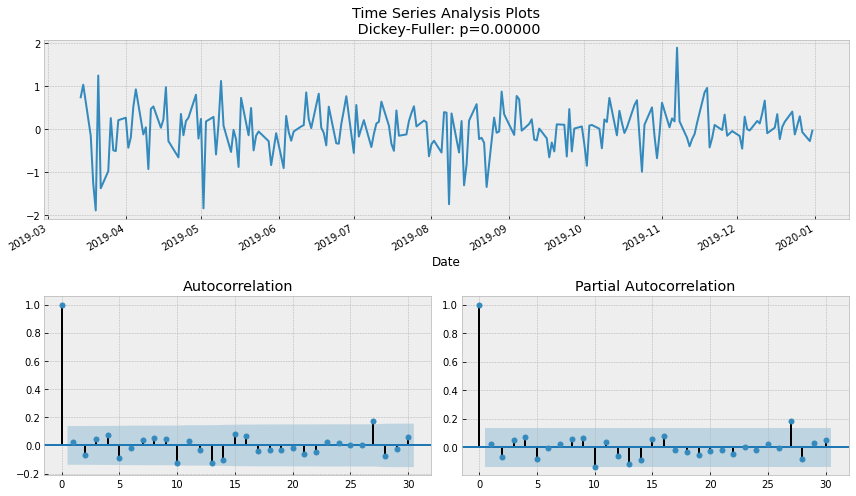

In [63]:
#Making plot stationary
#Therefore, to get rid of the high autocorrelation and to make the process stationary,
#let’s take the first difference: 
#We simply subtract the time series from itself with a lag of one day, and we get:
## Take the first difference to remove to make the process stationary
fox_diff = fox['Adj Close'] - fox['Adj Close'].shift(1)

tsplot(fox_diff[1:], lags=30)

In [64]:
#list columns of our dataset
fox.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [65]:
 # Shift Adj Close down to predict next day
pd.concat([fox['Adj Close'], fox['Adj Close'].shift(-1)], axis=1)

,Adj Close,Adj Close
Date,,
2019-03-13,38.081100,38.819408
2019-03-14,38.819408,39.849152
2019-03-15,39.849152,39.693718
2019-03-18,39.693718,38.421108
2019-03-19,38.421108,36.526764
...,...,...
2019-12-24,35.936131,36.231495
2019-12-26,36.231495,36.157654
2019-12-27,36.157654,35.877056


In [66]:
#adding more features - High Low Percentage and Percentage Change.
dfreg = fox.loc[:,['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (fox['High'] - fox['Low']) / fox['Close'] * 100.00
dfreg['PCT_change'] = (fox['Close'] - fox['Open']) / fox['Open'] * 100
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-12-24,35.936131,347100.0,0.849308,-0.300466
2019-12-26,36.231495,696700.0,0.978263,0.436681
2019-12-27,36.157654,832800.0,1.089181,-0.608937
2019-12-30,35.877056,894000.0,1.289795,-0.951352
2019-12-31,35.837673,988400.0,1.043959,0.220269


In [67]:
import math
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [68]:
# Drop missing values
dfreg = dfreg.fillna(value=-99999)

# Separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating label
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# scale the feature matrix X
X = preprocessing.scale(X)
# get train and test set
X_late = X[-forecast_out:]
X = X[:-forecast_out]
y = dfreg['label'][:-forecast_out]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

In [69]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(190, 4)
(11, 4)
(190,)
(11,)


In [70]:
#Prediction Using KNN
from sklearn.neighbors import KNeighborsRegressor

clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

confidenceknn = clfknn.score(X_test, y_test)
print("KNN Regression: ", confidenceknn)

KNN Regression:  -8.160162059766137


In [71]:
fox.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-24,36.799999,36.490002,36.610001,36.500000,347100.0,35.936131
2019-12-26,36.860001,36.500000,36.639999,36.799999,696700.0,36.231495
2019-12-27,36.950001,36.549999,36.950001,36.724998,832800.0,36.157654
2019-12-30,36.860001,36.389999,36.790001,36.439999,894000.0,35.877056
2019-12-31,36.525002,36.145000,36.320000,36.400002,988400.0,35.837673


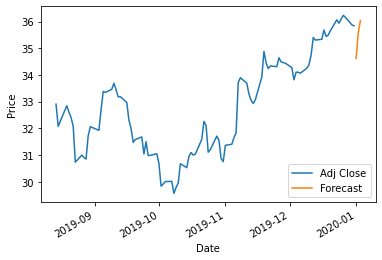

In [72]:
last_date = dfreg.iloc[-1].name

forecast_set = clfknn.predict(X_late)
dfreg['Forecast'] = np.nan



last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(100).plot()
dfreg['Forecast'].tail(100).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [73]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X, y)
X = fox.iloc[:,0:1].values
y = fox.iloc[:, 1].values

In [74]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [75]:
# Predicting a new result
samp = [[2012]]
y_pred = regressor.predict(samp)

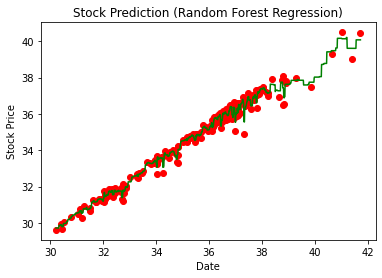

In [76]:
# Visualising the Random Forest Regression results
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'green')
plt.title('Stock Prediction (Random Forest Regression)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()